In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
import STAGATE
# os.environ['R_HOME'] = 'D:/anaconda/envs/stagate/Lib/R'
# os.environ['R_USER'] = 'D:/anaconda/envs/stagate/Lib/site-packages/rpy2'


151673
------Calculating spatial graph...
The graph contains 21124 edges, 3639 cells.
5.8049 neighbors per cell on average.
Size of Input:  (3639, 3000)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:25<00:00,  3.43it/s]


fitting ...
  |======================================================================| 100%
Adjusted rand index = 0.59
True
151674
------Calculating spatial graph...
The graph contains 21258 edges, 3673 cells.
5.7876 neighbors per cell on average.
Size of Input:  (3673, 3000)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:35<00:00,  3.22it/s]


fitting ...
  |======================================================================| 100%
Adjusted rand index = 0.37
True
151675
------Calculating spatial graph...
The graph contains 20762 edges, 3592 cells.
5.7801 neighbors per cell on average.
Size of Input:  (3592, 3000)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:34<00:00,  3.24it/s]


fitting ...
  |======================================================================| 100%
Adjusted rand index = 0.60
True
151676
------Calculating spatial graph...
The graph contains 20052 edges, 3460 cells.
5.7954 neighbors per cell on average.
Size of Input:  (3460, 3000)


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [02:28<00:00,  3.38it/s]


fitting ...
  |======================================================================| 100%
Adjusted rand index = 0.43
True


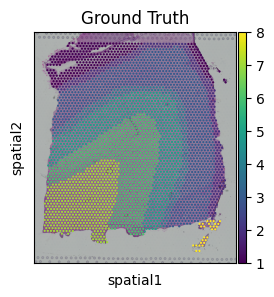

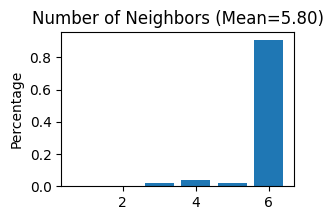

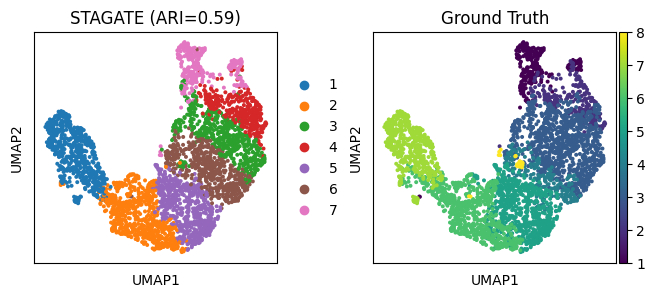

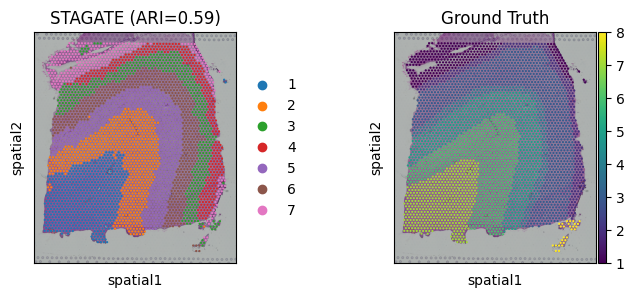

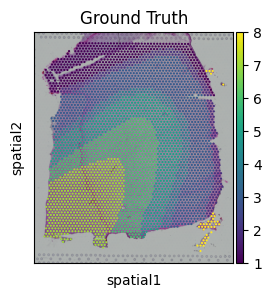

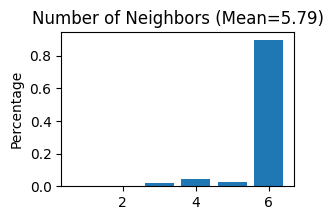

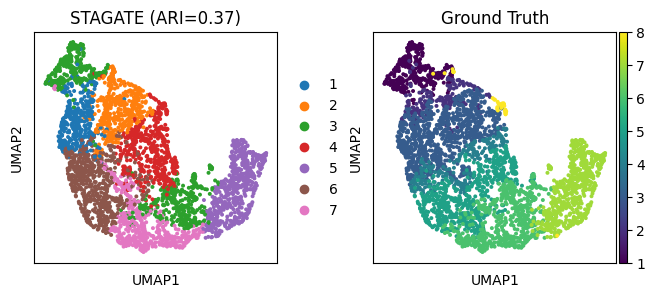

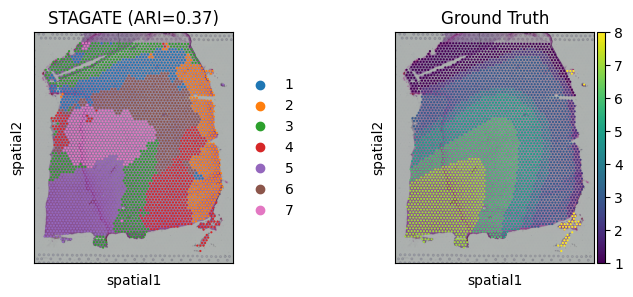

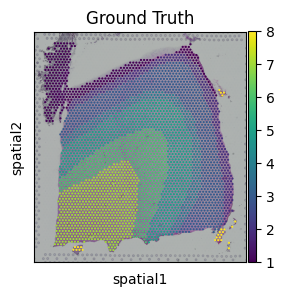

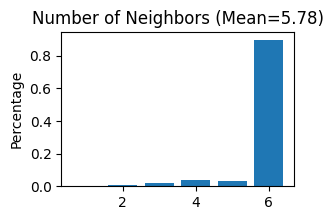

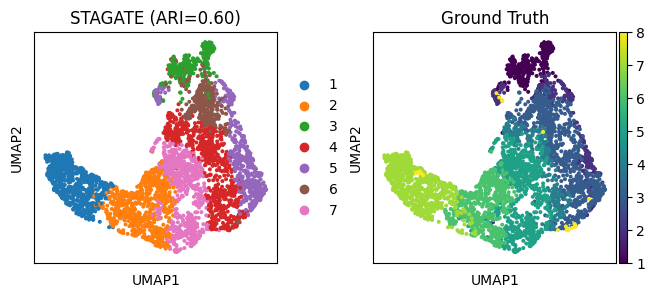

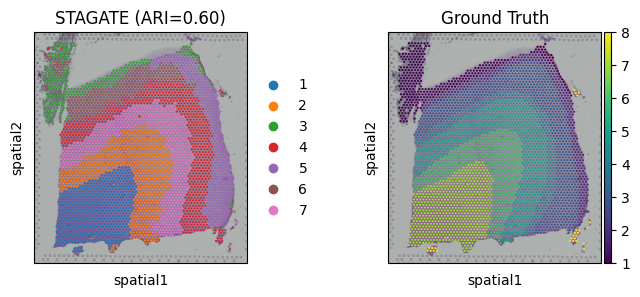

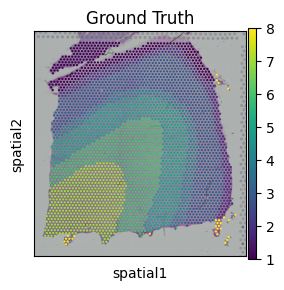

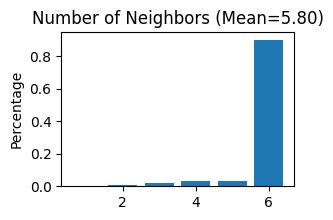

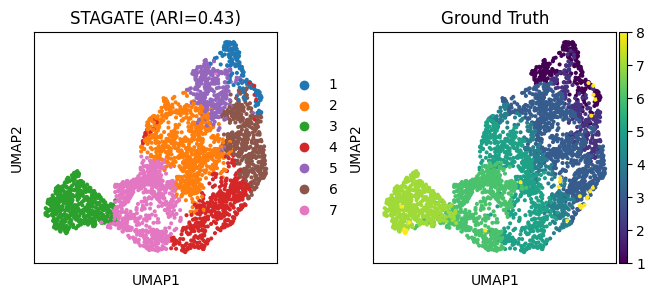

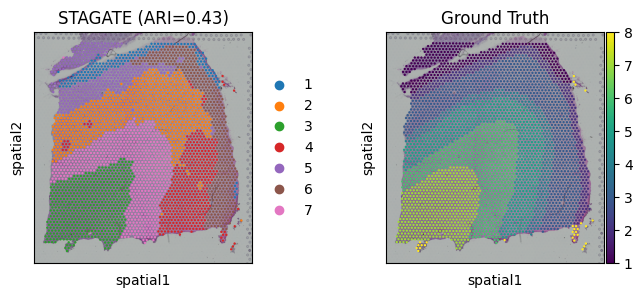

In [5]:
sample_list = ['151507','151508','151509','151510','151669','151670','151671','151672','151673','151674','151675','151676']
n_clusters = [7,7,7,7,5,5,5,5,7,7,7,7]
for i in range(8, len(sample_list)):
    section_id = sample_list[i]
    print(section_id)
    input_dir = os.path.join('G:/dataset/1_DLPFC/dataset', section_id)
    adata = sc.read_visium(path=input_dir, count_file='filtered_feature_bc_matrix.h5')
    adata.var_names_make_unique()

    #Normalization
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # read the annotation
    Ann_df = pd.read_csv(os.path.join('G:/dataset/1_DLPFC/groundtruth', section_id+'_groundtruth.csv'), sep=',')
    Ann_df = Ann_df.drop(['Unnamed: 0', 'id'], axis=1)
    Ann_df.set_index('cell8me', inplace = True)
    Ann_df.columns = ['Ground Truth']

    adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'Ground Truth']

    plt.rcParams["figure.figsize"] = (3, 3)
    sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], show = False)
    plt.savefig("./{}_spatial1.png".format(section_id), dpi = 500)

    STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
    STAGATE.Stats_Spatial_Net(adata)


    import tensorflow as tf
    tf.compat.v1.disable_eager_execution()
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"

    adata = STAGATE.train_STAGATE(adata, alpha=0)

    sc.pp.neighbors(adata, use_rep='STAGATE')
    sc.tl.umap(adata)
    adata = STAGATE.mclust_R(adata, used_obsm='STAGATE', num_cluster=n_clusters[i])

    obs_df = adata.obs.dropna()
    ARI = adjusted_rand_score(obs_df['mclust'], obs_df['Ground Truth'])
    print('Adjusted rand index = %.2f' %ARI)

    plt.rcParams["figure.figsize"] = (3, 3)
    sc.pl.umap(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"], show = False)
    plt.savefig("./{}_umap.png".format(section_id).format(section_id), dpi = 500)

    plt.rcParams["figure.figsize"] = (3, 3)
    sc.pl.spatial(adata, color=["mclust", "Ground Truth"], title=['STAGATE (ARI=%.2f)'%ARI, "Ground Truth"], show = False)
    plt.savefig("./{}_spatial2.png".format(section_id), dpi = 500)

    adata.filename = './{}.h5ad'.format(section_id)
    print(adata.isbacked)
